# Customer Analytics

Customer analytics is a process by which data from customer behavior is used to help make key business decisions via market segmentation and predictive analytics.

The goal of this project is to develop a model that predict customer behaviors and undestand the key features related to those behaviors.

## Content Table

[1. Script Configurations](#1.-Scripts-Configurations)  

[2. Explore the Dataset](#2.-Explore-the-Dataset)  

[3. Data Manipulation](#3.-Data-Manipulation)  

[4. Predictive Modeling](#4.-Predictive-Modeling)  
    [4.1. Evaluation Metrics](#4.1.-Evaluation-Metrics)  
    [4.2. Logistic Regression](#4.2.-Logistic-Regression)  
    [4.3. Feature Engineering](#4.3.-Feature-Engineering)  
    [4.4. Tackling Outliers](#4.4.-Tackling-Outliers)  
    [4.5. Feature Selection](#4.5.-Feature-Selection)  
    [4.6. Results](#4.6.-Results)  

[5. Customer Segmentation](#5.-Customer-Segmentation)  
    [5.1. RFM](#5.1.-RFM)  
    [5.2. Clustering](#5.2.-Clustering)  

[6. Future Work](#6.-Future-Work)

## 1. Scripts Configurations
---

In this first section, we are going to import the Python modules used throughout this project, as well as define some global configurations.

In [1]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from itertools import combinations
from scipy.stats import iqr, pearsonr, ttest_ind
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, roc_auc_score, silhouette_score
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Configurations
np.random.seed(1)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
# Global variables
TARGET_FEATURE = 'Response'
TEST_SIZE = 0.25

## 2. Explore the Dataset
---

Let's have a first look at the data and see what insights we can obtain.

In [4]:
# Load the dataset
DATASET_PATH = 'datasets'
dataframe = pd.read_csv(f'{DATASET_PATH}/customers.csv')
dataframe.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [5]:
# Dataset shape
print(f'dataset shape: {dataframe.shape}')

dataset shape: (2240, 29)


In [6]:
# Features and types
dataframe.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

In [7]:
# Check for missing or null values
print(f'number of missing values: {dataframe.isna().sum().sum()}')

number of missing values: 24


In [8]:
# Locating the missing data
count = dataframe[TARGET_FEATURE][dataframe['Income'].isna()].sum()
print(f'number of people that accepted the offer and has missing values: {count}')
dataframe.isna().sum()

number of people that accepted the offer and has missing values: 1


ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [9]:
# Dataset statistics
dataframe.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [10]:
# Number of unique values
dataframe.nunique()

ID                     2240
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1974
Kidhome                   3
Teenhome                  3
Dt_Customer             663
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         558
MntFishProducts         182
MntSweetProducts        177
MntGoldProds            213
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

In [11]:
# Categorical values
for feature in ['Education', 'Marital_Status']:
    print(f'{feature}: {dataframe[feature].unique()}')
    print(dataframe[feature].value_counts())
    print('-' * 80)

Education: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64
--------------------------------------------------------------------------------
Marital_Status: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64
--------------------------------------------------------------------------------


In [12]:
# Count
dataframe[TARGET_FEATURE].value_counts()

0    1906
1     334
Name: Response, dtype: int64

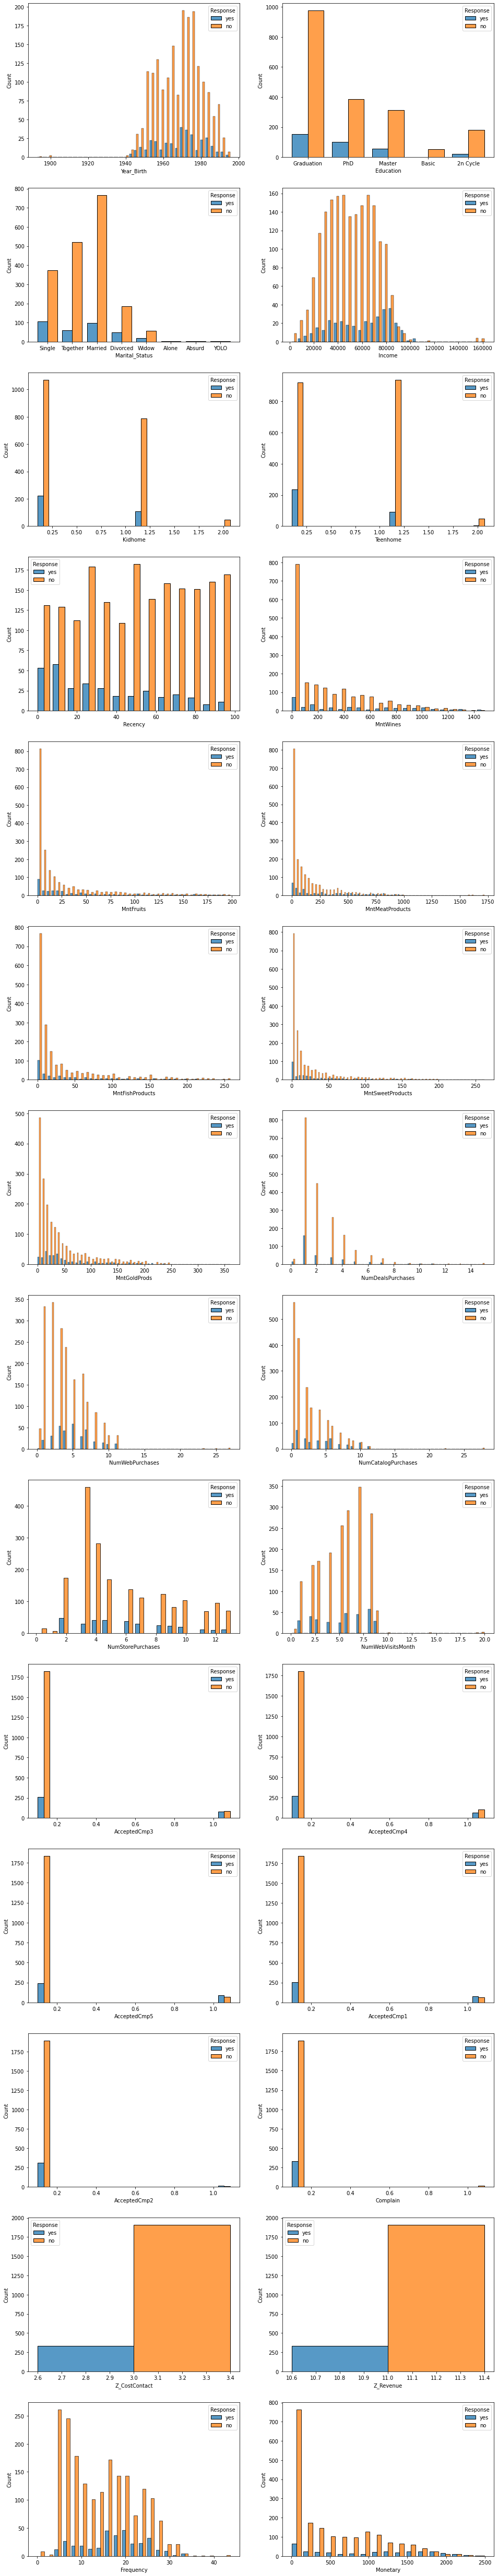

In [13]:
# Features vs response (absolute)
dataframe_copy = dataframe.copy()
dataframe_copy[TARGET_FEATURE] = dataframe_copy[TARGET_FEATURE].replace({0: 'no', 1: 'yes'})

dataframe_copy['Income'] = dataframe_copy['Income'].where(dataframe_copy['Income'] < 200000)
dataframe_copy['Frequency'] = dataframe_copy['NumCatalogPurchases'] + dataframe_copy['NumDealsPurchases'] + dataframe_copy['NumStorePurchases'] + dataframe_copy['NumWebPurchases']
dataframe_copy['Monetary'] = dataframe_copy['MntFishProducts'] + dataframe_copy['MntFruits'] + dataframe_copy['MntGoldProds'] + dataframe_copy['MntMeatProducts'] + dataframe_copy['MntSweetProducts'] + dataframe_copy['MntWines']

_, ax = plt.subplots(nrows=14, ncols=2, figsize=(16, 90))
i, j = 0, 0

for feature in dataframe_copy:
    if feature not in [TARGET_FEATURE, 'Dt_Customer', 'ID']:
        sns.histplot(
            x=feature,
            hue=TARGET_FEATURE,
            data=dataframe_copy,
            shrink=.8,
            multiple='dodge',
            ax=ax[i, j]
        )
        i = i+1 if j != 0 else i
        j = j+1 if j == 0 else 0

After exporing the data, here are some conclusions that we can take:
- some features can be dropped as they don't contribute to our problem
- some features have categorical values
- there are missing values
- one feature has date values
- some feature are heavily skewed

Moreover, with the visualization of the features with respect to our target variable, some insights are:
- people accept more offers as they're income grows
- people with less recency tend to accept more offers
- people who is married or together tend to accept less offers

## 3. Data Manipulation

Before starting to model the data, we have to reorganize it so the machine understand it better.

In [14]:
# Drop irrelevant columns
processed_dataframe = dataframe.drop(['ID', 'Z_CostContact', 'Z_Revenue'], axis=1)

In [15]:
# Replace categorical values

# marital status
feature = 'Marital_Status'
column = processed_dataframe.pop(feature)
new_columns = pd.get_dummies(column, prefix=feature)
processed_dataframe = pd.concat([processed_dataframe, new_columns], axis=1)

# education
feature = 'Education'
processed_dataframe[feature] = processed_dataframe[feature].replace({
     '2n Cycle': 0, 'Basic': 1, 'Graduation': 2, 'Master': 3, 'PhD': 4
})

In [16]:
# Removing people with missing data

# disclaimer:
# although we already have few samples, since only 1 person that accepted the offer has missing values,
# I am willing to drop them, instead of filling the missing values with some inference.

processed_dataframe = processed_dataframe[~dataframe['Income'].isna()]

In [17]:
# Handling dates
today_date = pd.to_datetime('2021-02-16')
customer_enrollment_str = processed_dataframe.pop('Dt_Customer')
customer_enrollment_date = pd.to_datetime(customer_enrollment_str)
processed_dataframe['DaysWithTheCompany'] = (today_date - customer_enrollment_date).astype('timedelta64[D]')

In [18]:
# New dataset shape
print(f'new dataset shape: {processed_dataframe.shape}')

new dataset shape: (2216, 33)


## 4. Predictive Modeling
---

Now it's time to use some statistics and machine learning to classify the customers in respect of their response to the company's offer.

In [19]:
# Split dataset
x = processed_dataframe.drop(TARGET_FEATURE, axis=1)
y = processed_dataframe[TARGET_FEATURE]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=0)
print(f'train size: {len(x_train)}')
print(f'test size: {len(x_test)}')

train size: 1662
test size: 554


In [20]:
# Scale dataset
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)
y_train = y_train.values
y_test = y_test.values

In [21]:
# Significance level between train and test
_, p_value = ttest_ind(x_train_norm, x_test_norm)
for i, feature in enumerate(x):
    print(f'{feature}: {p_value[i]}')

Year_Birth: 0.524583193761555
Education: 0.6390749701458708
Income: 0.02098278381870735
Kidhome: 0.11499924780025254
Teenhome: 0.20697949199780913
Recency: 0.20621574225394007
MntWines: 0.10116666593780531
MntFruits: 0.22364696792413472
MntMeatProducts: 0.05325522646847109
MntFishProducts: 0.03645271855141733
MntSweetProducts: 0.27347787234435544
MntGoldProds: 0.1795520055248441
NumDealsPurchases: 0.31083223228001006
NumWebPurchases: 0.3498064210440328
NumCatalogPurchases: 0.07911262711558066
NumStorePurchases: 0.14430686029403114
NumWebVisitsMonth: 0.062031167803153445
AcceptedCmp3: 0.541561523052581
AcceptedCmp4: 0.5741786520538352
AcceptedCmp5: 0.5097151356373947
AcceptedCmp1: 0.9202599940778319
AcceptedCmp2: 0.5244829082418971
Complain: 0.8993217404377065
Marital_Status_Absurd: 0.4142337423565996
Marital_Status_Alone: 0.3172011549222873
Marital_Status_Divorced: 0.6309006165938309
Marital_Status_Married: 0.8601455343302682
Marital_Status_Single: 0.21920232956955502
Marital_Status_To

### 4.1. Evaluation Metrics

To evaluate the models' performance, some metrics and techniques were choosen:
- precision: is the number of true positives, divided by the total number of predicted positive samples.
- recall (sensitivity): is the number of true positives, divided by the total number of actual positive samples.
- specificity (inside roc auc): is the number of true negatives, divided by the total number of actual negative samples.
- roc auc: it tells how much the model is capable of distinguishing between classes by varying its threshold.
- cross-validation: is a resampling technique used to evaluate models on a limited data sample.
- grid search: is a exhastive search of specific parameter values for an estimator.
- learning curves: is used to evaluate bias and variance of a model.

In [22]:
# Train function
CV = 5

def train(x, y, model_class):

    # Grid search
    grid_search = GridSearchCV(
        model_class(),
        model_class.PARAMS,
        scoring={
            'precision': 'precision',
            'recall': 'recall',
            'roc_auc': 'roc_auc'
        },
        refit='roc_auc',
        cv=CV,
        return_train_score=True
    )
    grid_search.fit(x, y)
    cv_results = grid_search.cv_results_
    best_params = grid_search.best_params_
    best_index = grid_search.best_index_

    # Compute learning curves
    set_size, train_error, test_error = \
        learning_curve(model_class(**best_params), x, y, cv=CV, train_sizes=np.linspace(0.02, 1, 100), scoring='roc_auc')
    learning_curves = np.array([set_size, train_error.mean(axis=1), test_error.mean(axis=1)])
    plt.figure(figsize=(12, 6))
    plt.plot(learning_curves[0, :], learning_curves[1, :], label='training')
    plt.plot(learning_curves[0, :], learning_curves[2, :], label='validation')
    plt.legend(loc='best')
    plt.ylim(0, 1)
    plt.ylabel('Error', size=16)
    plt.xlabel('Number of training samples', size=16)

    # Compute scores
    results = {
        'precision': cv_results[f'mean_test_precision'][best_index],
        'recall': cv_results[f'mean_test_recall'][best_index],
        'roc_auc': cv_results[f'mean_test_roc_auc'][best_index],
        'model': grid_search.best_estimator_,
        'best_params': best_params,
        'learning_curves': learning_curves
    }

    print(f'precision: {results["precision"]}')
    print(f'recall: {results["recall"]}')
    print(f'roc_auc: {results["roc_auc"]}')
    print(f'best_params: {results["best_params"]}')
    return results

In [23]:
# Test function
def test(x, y, model):
    y_pred = model.predict(x)
    scores = {
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'roc_auc': roc_auc_score(y, y_pred)
    }
    print(f'precision: {scores["precision"]}')
    print(f'recall: {scores["recall"]}')
    print(f'roc_auc: {scores["roc_auc"]}')
    plot_confusion_matrix(model, x, y)

### 4.2. Logistic Regression

Logistic Regression was chosen because it's a model that's easy to undestand, does not need a lot of data to reach good results and can handle imbalance datasets.

In [24]:
class MyLogisticRegression(LogisticRegression):
    PARAMS = {
        'C': np.arange(1e-9, 1000, 100),
        'l1_ratio': [0, 0.5, 1]
    }
    def __init__(self, C=1, l1_ratio=None):
        LogisticRegression.__init__(
            self,
            C=C,
            l1_ratio=l1_ratio,
            solver='saga',
            penalty='elasticnet',
            class_weight='balanced',
            random_state=0
        )

precision: 0.42383317168804363
recall: 0.772734693877551
roc_auc: 0.8814688595987841
best_params: {'C': 100.000000001, 'l1_ratio': 1}


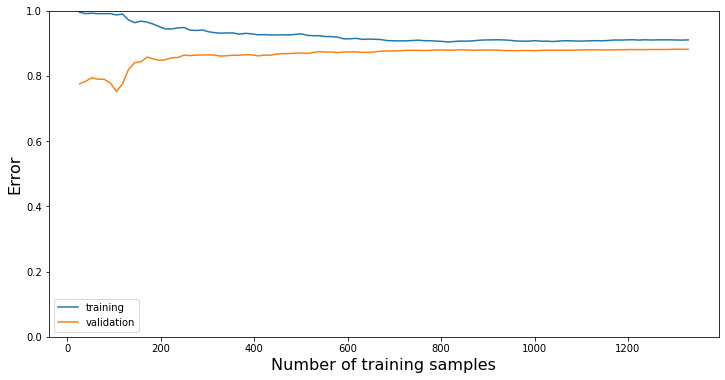

In [25]:
# Train
results = train(x_train_norm, y_train, MyLogisticRegression)

### 4.3. Feature Engineering

Let's now create and change some features to see if our model has better scorings.

In [26]:
x_eng = x.copy()

In [27]:
# Create new feature
frequency = x_eng['NumCatalogPurchases'] + x_eng['NumDealsPurchases'] + x_eng['NumStorePurchases'] + x_eng['NumWebPurchases']
monetary = x_eng['MntFishProducts'] + x_eng['MntFruits'] + x_eng['MntGoldProds'] + x_eng['MntMeatProducts'] + x_eng['MntSweetProducts'] + x_eng['MntWines']

r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

r = pd.qcut(x_eng['Recency'], q=4, labels=r_labels)
f = pd.qcut(frequency, q=4, labels=f_labels)
m = pd.qcut(monetary, q=4, labels=m_labels)

x_eng['RFM'] = r.astype(int) + f.astype(int) + m.astype(int)

In [28]:
# Transform features
FEATURES = [
    'Year_Birth', 'MntWines', 'MntFruits',
    'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntGoldProds',
    'DaysWithTheCompany'
]
for feature in FEATURES:
    x_eng[feature] = np.log1p(x_eng[feature])

In [29]:
# Split dataset
x_train_eng, x_test_eng, y_train_eng, y_test_eng = train_test_split(x_eng, y, test_size=TEST_SIZE, random_state=0)

In [30]:
# Scale dataset
scaler = StandardScaler()
x_train_eng_norm = scaler.fit_transform(x_train_eng)
y_train_eng = y_train_eng.values

precision: 0.42816728696512696
recall: 0.772734693877551
roc_auc: 0.8859335904371205
best_params: {'C': 100.000000001, 'l1_ratio': 1}


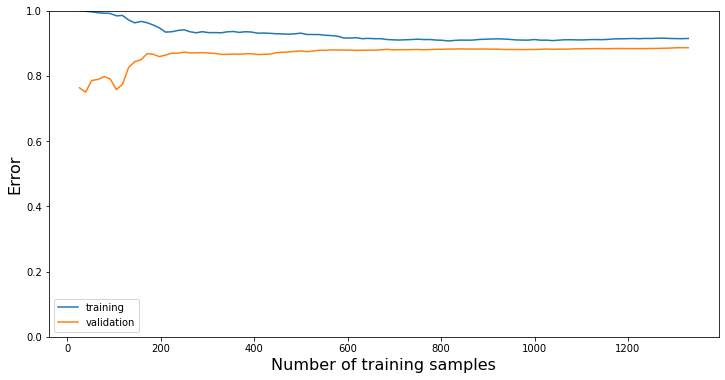

In [31]:
# Train
results = train(x_train_eng_norm, y_train_eng, MyLogisticRegression)

### 4.4. Tackling Outliers

Maybe eliminating outliers improves our model's performance.

In [32]:
x_train_outlier = x_train_eng.copy()
x_test_outlier = x_test_eng.copy()

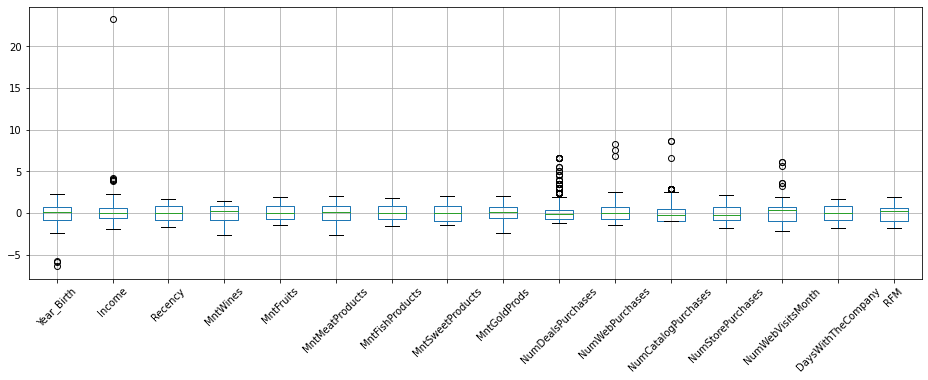

In [33]:
# Box plots
NUMERIC_FEATURES = [
    'Year_Birth', 'Income', 'Recency',
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
    'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
    'NumWebVisitsMonth', 'DaysWithTheCompany', 'RFM'
]
x_box_plot = StandardScaler().fit_transform(x_train_outlier)
x_box_plot = pd.DataFrame(x_box_plot, columns=x_train_outlier.columns)
plt.figure(figsize=(16, 5))
x_box_plot[NUMERIC_FEATURES].boxplot()
_ = plt.xticks(rotation = 45)

In [34]:
# Remove outliers
initial_length = len(x_train_outlier)
x_train_dataframe = x_train_outlier.copy()
y_train_dataframe = pd.DataFrame(y_train, index=x_train.index)

for feature in NUMERIC_FEATURES:
    values = x_train_dataframe[feature]
    upper_limit = np.quantile(values, 0.75) + 1.5 * iqr(values)
    lower_limit = np.quantile(values, 0.25) - 1.5 * iqr(values)
    conditional = (values < upper_limit) & (values > lower_limit)
    x_train_dataframe = x_train_dataframe[conditional]
    y_train_dataframe = y_train_dataframe[conditional]

x_train_outlier = x_train_dataframe
y_train_outlier = y_train_dataframe.values

print(f'number of outliers: {initial_length - len(x_train_outlier)}')

number of outliers: 175


In [35]:
# New dataset shape
print(f'new dataset shape: {x_train_outlier.shape}')

new dataset shape: (1487, 33)


In [36]:
# Scale dataset
scaler = StandardScaler()
x_train_outlier_norm = scaler.fit_transform(x_train_outlier)
x_test_outlier_norm = scaler.fit_transform(x_test_outlier)

precision: 0.42877962422402566
recall: 0.79
roc_auc: 0.8931158190812294
best_params: {'C': 100.000000001, 'l1_ratio': 1}


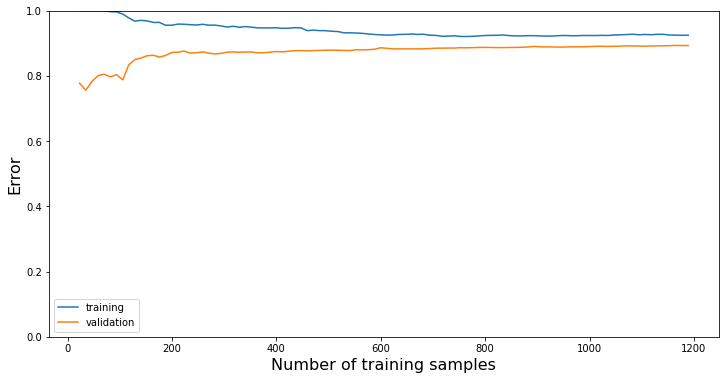

In [37]:
# Train
results = train(x_train_outlier_norm, y_train_outlier, MyLogisticRegression)

### 4.5. Feature Selection

Let's use hypothesis test to keep only the features that have some significant variance between the distribution of classes.

In [38]:
x_train_select = x_train_outlier.copy()
x_test_select = x_test_eng.copy()
y_train_select = y_train_outlier.copy()

In [39]:
# Statistical significance

features_to_remove = []
for feature in x_train_select:
    x_0 = x_train_select[y_train_select == 0]
    x_1 = x_train_select[y_train_select == 1]
    _, p_value = ttest_ind(x_0[feature], x_1[feature])
    if p_value > 0.05:
        features_to_remove.append(feature)

features_to_remove

['Year_Birth',
 'NumDealsPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Complain',
 'Marital_Status_Absurd',
 'Marital_Status_Alone',
 'Marital_Status_Divorced',
 'Marital_Status_Widow',
 'Marital_Status_YOLO']

In [40]:
# Removing features
x_train_select = x_train_select.drop(features_to_remove, axis=1)
x_test_select = x_test_select.drop(features_to_remove, axis=1)

In [41]:
# Scale dataset
scaler = StandardScaler()
x_train_select_norm = scaler.fit_transform(x_train_select)
x_test_select_norm = scaler.transform(x_test_select)

In [42]:
# New dataset shape
print(f'new dataset shape: {x_train_select.shape}')

new dataset shape: (1487, 23)


precision: 0.4081688509722807
recall: 0.78
roc_auc: 0.8792864145024584
best_params: {'C': 700.000000001, 'l1_ratio': 0}


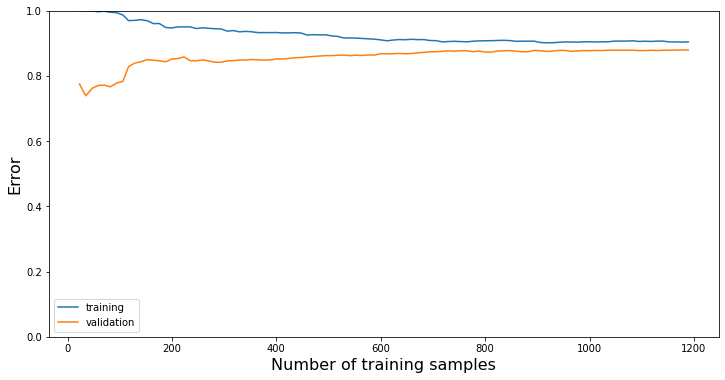

In [43]:
# Train
_ = train(x_train_select_norm, y_train_select, MyLogisticRegression)  # ignore result since it had lower performance

### 4.6. Results

precision: 0.5033112582781457
recall: 0.8735632183908046
roc_auc: 0.8564818233281646


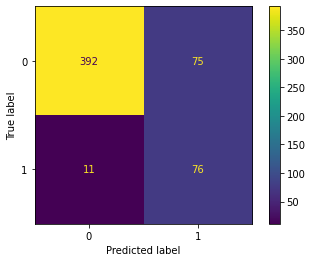

In [44]:
# Test
test(x_test_outlier_norm, y_test, results['model'])

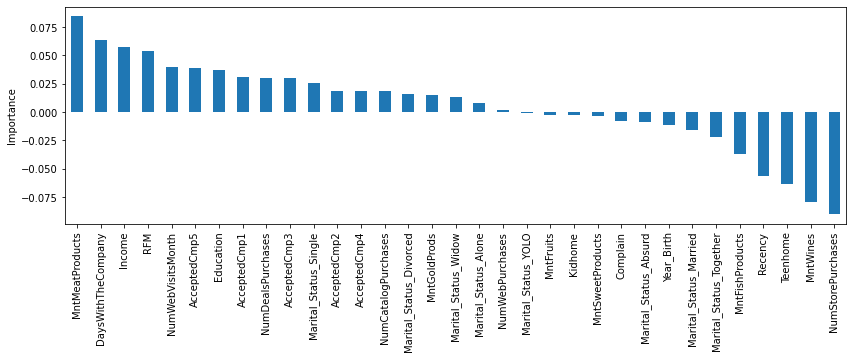

In [45]:
# Feature importance
model = results['model']
importances = pd.Series(model.coef_[0, :], index=x_train_outlier.columns)
importances = importances.sort_values(ascending=False)
importances = importances / importances.apply(abs).sum()
plt.subplots(figsize=(14, 4))
importances.plot(kind='bar')
_ = plt.ylabel('Importance')

In [46]:
importances

MntMeatProducts            0.084185
DaysWithTheCompany         0.063433
Income                     0.057099
RFM                        0.053609
NumWebVisitsMonth          0.039775
AcceptedCmp5               0.038741
Education                  0.037434
AcceptedCmp1               0.031091
NumDealsPurchases          0.029609
AcceptedCmp3               0.029594
Marital_Status_Single      0.025455
AcceptedCmp2               0.018704
AcceptedCmp4               0.018652
NumCatalogPurchases        0.018152
Marital_Status_Divorced    0.016010
MntGoldProds               0.014836
Marital_Status_Widow       0.012882
Marital_Status_Alone       0.008003
NumWebPurchases            0.001802
Marital_Status_YOLO       -0.000664
MntFruits                 -0.002345
Kidhome                   -0.002745
MntSweetProducts          -0.003241
Complain                  -0.007450
Marital_Status_Absurd     -0.009055
Year_Birth                -0.011395
Marital_Status_Married    -0.016103
Marital_Status_Together   -0

<AxesSubplot:>

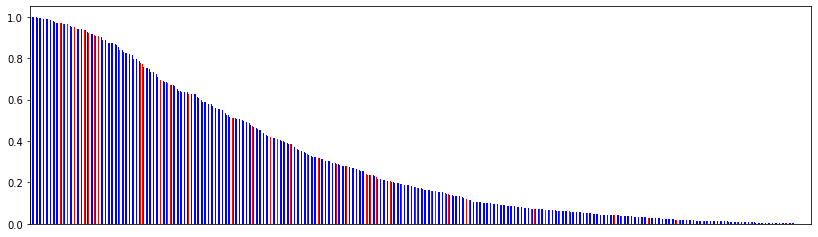

In [47]:
# Acceptance probability
probabilities = model.predict_proba(x_test_outlier_norm)
response_probabilities = pd.Series(probabilities[:, 1]).sort_values(ascending=False)
_, ax = plt.subplots(figsize=(14, 4))
ax.get_xaxis().set_visible(False)
colors = ['r' if i == 1 else 'b' for i in y_test]
response_probabilities.plot.bar(color=colors)

<AxesSubplot:>

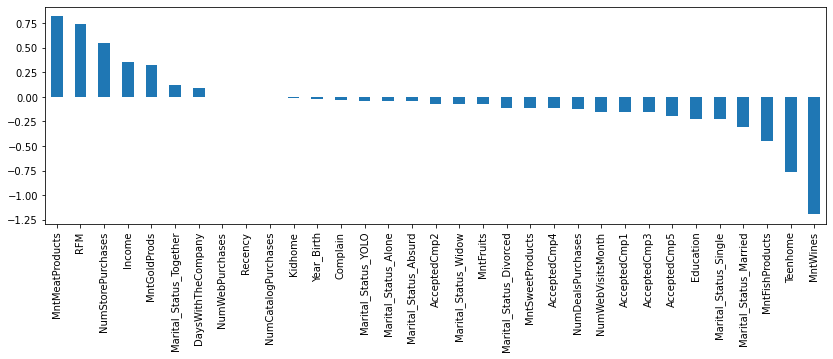

In [48]:
# Feature relevance per sample
coef = model.coef_[0, :]
intercept = model.intercept_
sample = x_test_outlier_norm[0:1, :]

relevance = (sample * coef) + (intercept / sample.shape[1])
relevance = pd.Series(relevance[0, :], index=x_train_outlier.columns)
relevance = relevance.sort_values(ascending=False)

plt.subplots(figsize=(14, 4))
relevance.plot(kind='bar')

## 5. Customer Segmentation
---

Customer segmentation is the process of dividing customers into groups based on common characteristics.

In the section we will apply machine learning and marketing segmentation analysis to get insights of our data.

### 5.1. RFM

- lost: customers with high recency, low frequency and low monetary
- hibernating: customer slightly better than lost customers
- about to sleep: customer slightly better than lost hibernating
- champions: customers who bought most recently, most often, and are heavy spenders
- potential loyalists: recent customers with average frequency and who spent a good amount
- loyal: customers who have good RFM, specially frequency
- need attention: customers with high recency and low frequency, but spend good amount of money
- cannot lose: customers who used to visit and purchase quite often, but haven’t been visiting recently

In [49]:
# Create features
rfm_dataframe = processed_dataframe[[TARGET_FEATURE, 'Recency']]

rfm_dataframe['Frequency'] = processed_dataframe['NumCatalogPurchases'] + processed_dataframe['NumDealsPurchases'] + processed_dataframe['NumStorePurchases'] + processed_dataframe['NumWebPurchases']
rfm_dataframe['Monetary'] = processed_dataframe['MntFishProducts'] + processed_dataframe['MntFruits'] + processed_dataframe['MntGoldProds'] + processed_dataframe['MntMeatProducts'] + processed_dataframe['MntSweetProducts'] + processed_dataframe['MntWines']

r_labels = range(5, 0, -1)
f_labels = range(1, 6)
m_labels = range(1, 6)

rfm_dataframe['R'] = pd.qcut(rfm_dataframe['Recency'], q=5, labels=r_labels).astype(str)
rfm_dataframe['F'] = pd.qcut(rfm_dataframe['Frequency'], q=5, labels=f_labels).astype(str)
rfm_dataframe['M'] = pd.qcut(rfm_dataframe['Monetary'], q=5, labels=m_labels).astype(str)

rfm_dataframe['RFM'] = rfm_dataframe['R'] + rfm_dataframe['F'] + rfm_dataframe['M']

In [50]:
# Segmentation
rfm_dataframe['Segment'] = 'lost'
rfm_dataframe['Segment'] = np.where(rfm_dataframe['RFM'] > '111', 'hibernating', rfm_dataframe['Segment'])
rfm_dataframe['Segment'] = np.where(rfm_dataframe['RFM'] >= '222', 'about_to_sleep', rfm_dataframe['Segment'])
rfm_dataframe['Segment'] = np.where(rfm_dataframe['RFM'] >= '333', 'potential_loyalist', rfm_dataframe['Segment'])
rfm_dataframe['Segment'] = np.where(rfm_dataframe['RFM'] >= '444', 'champion', rfm_dataframe['Segment'])
rfm_dataframe['Segment'] = np.where(((rfm_dataframe['Segment'] == 'potential_loyalist') & (rfm_dataframe['F'] >= '4')), 'loyal', rfm_dataframe['Segment'])
rfm_dataframe['Segment'] = np.where(((rfm_dataframe['Segment'] == 'about_to_sleep') & (rfm_dataframe['M'] >= '4')), 'need_attention', rfm_dataframe['Segment'])
rfm_dataframe['Segment'] = np.where(((rfm_dataframe['Segment'] == 'hibernating') & (rfm_dataframe['F'] >= '4') & (rfm_dataframe['M'] >= '4')), 'cannot_lose', rfm_dataframe['Segment'])

In [51]:
# Number per segment
rfm_dataframe['Segment'].value_counts()

champion              596
potential_loyalist    344
about_to_sleep        335
hibernating           317
loyal                 201
need_attention        192
cannot_lose           154
lost                   77
Name: Segment, dtype: int64

In [52]:
# Response per segment
groups = []
for segment in rfm_dataframe['Segment'].unique():
    samples = rfm_dataframe[rfm_dataframe['Segment'] == segment]
    total_samples = len(samples)
    responses = samples[TARGET_FEATURE].sum()
    rate = responses / total_samples
    groups.append({
        'segment': segment,
        'total_samples': total_samples,
        'rate': rate
    })
groups_sorted = sorted(groups, key=lambda item: item['rate'], reverse=True)
groups_sorted

[{'segment': 'champion', 'total_samples': 596, 'rate': 0.28859060402684567},
 {'segment': 'need_attention',
  'total_samples': 192,
  'rate': 0.18229166666666666},
 {'segment': 'loyal', 'total_samples': 201, 'rate': 0.17412935323383086},
 {'segment': 'cannot_lose', 'total_samples': 154, 'rate': 0.12337662337662338},
 {'segment': 'potential_loyalist',
  'total_samples': 344,
  'rate': 0.10755813953488372},
 {'segment': 'about_to_sleep',
  'total_samples': 335,
  'rate': 0.05970149253731343},
 {'segment': 'hibernating', 'total_samples': 317, 'rate': 0.0473186119873817},
 {'segment': 'lost', 'total_samples': 77, 'rate': 0.0}]

### 5.2. Clustering

In [53]:
# scale and transform
x_norm = StandardScaler().fit_transform(processed_dataframe)
x_tsne = TSNE(n_components=2).fit_transform(x_norm)

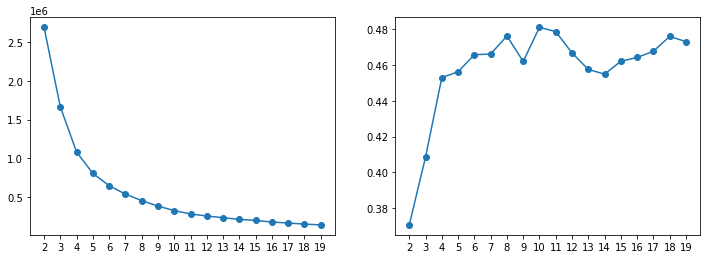

In [54]:
# Find the number of clusters
MAX_K = 20

# elbow method
inertias = []
for k in range(2, MAX_K):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1)
    kmeans.fit(x_tsne)
    inertias.append(kmeans.inertia_)

# silhouette method
silhouettes = []
for k in range(2, MAX_K):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1)
    kmeans.fit(x_tsne)
    score = silhouette_score(x_tsne, kmeans.labels_)
    silhouettes.append(score)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].set_xticks(range(2, MAX_K))
ax[1].set_xticks(range(2, MAX_K))
ax[0].plot(range(2, MAX_K), inertias, marker='o')
ax[1].plot(range(2, MAX_K), silhouettes, marker='o')

In [55]:
# Clusters response
kmeans = KMeans(n_clusters=10, n_init=20, random_state=1)
clusters = kmeans.fit_predict(x_tsne)
df_clusters = y.to_frame()
df_clusters['Cluster'] = clusters
response_per_cluster = []
for cluster in np.unique(clusters):
    df_selected = df_clusters[df_clusters['Cluster'] == cluster]
    total_samples = len(df_selected)
    response_samples = len(df_selected[df_selected[TARGET_FEATURE] == 1])
    response_per_cluster.append({
        'total_samples': total_samples,
        'response_samples': response_samples,
        'response_rate': response_samples / total_samples,
        'cluster': cluster
    })
response_per_cluster_sorted = sorted(response_per_cluster, key=lambda item: item['response_rate'], reverse=True)
response_per_cluster_sorted

[{'total_samples': 232,
  'response_samples': 99,
  'response_rate': 0.4267241379310345,
  'cluster': 5},
 {'total_samples': 121,
  'response_samples': 45,
  'response_rate': 0.371900826446281,
  'cluster': 6},
 {'total_samples': 195,
  'response_samples': 48,
  'response_rate': 0.24615384615384617,
  'cluster': 2},
 {'total_samples': 75,
  'response_samples': 17,
  'response_rate': 0.22666666666666666,
  'cluster': 8},
 {'total_samples': 213,
  'response_samples': 36,
  'response_rate': 0.16901408450704225,
  'cluster': 1},
 {'total_samples': 297,
  'response_samples': 40,
  'response_rate': 0.13468013468013468,
  'cluster': 4},
 {'total_samples': 243,
  'response_samples': 20,
  'response_rate': 0.0823045267489712,
  'cluster': 9},
 {'total_samples': 220,
  'response_samples': 9,
  'response_rate': 0.04090909090909091,
  'cluster': 3},
 {'total_samples': 341,
  'response_samples': 12,
  'response_rate': 0.03519061583577713,
  'cluster': 0},
 {'total_samples': 279,
  'response_samples

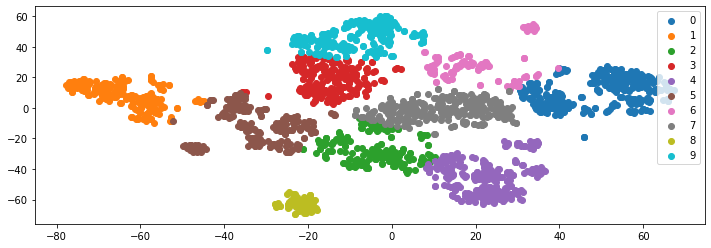

In [56]:
# Visualize clusters
plt.figure(figsize=(12, 4))
for cluster in np.unique(clusters):
    plt.scatter(x_tsne[clusters == cluster, 0], x_tsne[clusters == cluster, 1], label=cluster)
plt.legend(loc='best')

## 6. Future Work
---

With predictive and clustering analysis we could select people and groups that are most likely to accept the offer (up to 50%).

But we can still go further.  
Here's some things we can try:
- remove colinearity and multicollinearity features
- use non-linear and ensemble models
- combine predictive and clustering analytics
- gather more positive samples
- add more features like customer region and gender